In [5]:
# Cell 1: Imports and Data Loading
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input

# 1. Data Curation: Load Malaria Dataset from TensorFlow Datasets
# This satisfies the requirement for a "Public Dataset"
print("Downloading data...")
dataset, info = tfds.load('malaria', with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:]'])
train_raw, test_raw = dataset[0], dataset[1]

# Define Constants
IMG_SIZE = 128
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# 2. Preprocessing (Resizing & Normalization)
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

# Apply preprocessing
train_ds = train_raw.map(preprocess).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_raw.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"Data loaded. Classes: {info.features['label'].names}")
# Label 0: Parasitized, Label 1: Uninfected (Note: In this dataset, usually 0=Parasitized, 1=Uninfected or vice versa. We will verify).

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.2SE9DP_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
Data loaded. Classes: ['parasitized', 'uninfected']


Sample Images (0=Parasitized, 1=Uninfected):


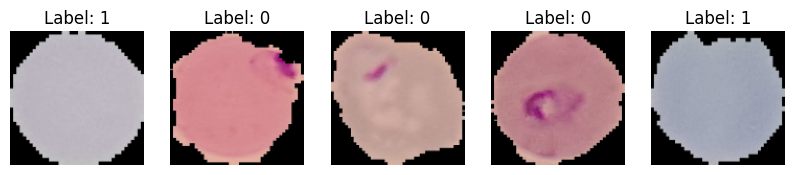

In [6]:
# Cell 2: EDA - Visualize Samples
def show_samples(dataset, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i, (image, label) in enumerate(dataset.unbatch().take(num_samples)):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"Label: {int(label)}")
        plt.axis("off")
    plt.show()

print("Sample Images (0=Parasitized, 1=Uninfected):")
show_samples(train_ds)

In [7]:
# Cell 3: Baseline Model (Simple CNN)
# Requirement: "Train a simple baseline to establish a floor"

from tensorflow.keras import layers, models, callbacks

def build_baseline():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid') # Binary classification
    ])
    return model

baseline_model = build_baseline()
baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# Early Stopping (Mandatory Requirement)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("Training Baseline Model...")
history_baseline = baseline_model.fit(train_ds, validation_data=test_ds, epochs=10, callbacks=[early_stop])

Training Baseline Model...
Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - accuracy: 0.6599 - loss: 0.6557 - precision: 0.6456 - recall: 0.7450 - val_accuracy: 0.9216 - val_loss: 0.2139 - val_precision: 0.9346 - val_recall: 0.9052
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9206 - loss: 0.2134 - precision: 0.9195 - recall: 0.9239 - val_accuracy: 0.9345 - val_loss: 0.1913 - val_precision: 0.9338 - val_recall: 0.9341
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.9353 - loss: 0.1823 - precision: 0.9389 - recall: 0.9324 - val_accuracy: 0.9323 - val_loss: 0.2163 - val_precision: 0.9348 - val_recall: 0.9283
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9426 - loss: 0.1548 - precision: 0.9475 - recall: 0.9380 - val_accuracy: 0.9184 - val_loss: 0.2324 - val_precision: 0.9521 - val_recall: 0.8796
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.9434 - loss: 0.1403 - precision: 0.9513 - recall: 0.9361 

In [8]:
# Cell 4: Advanced Model (Functional API Fix)
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, callbacks

def build_advanced_model():
    # 1. Setup Base Model
    base_model = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    # 2. Build Model using Functional API (Fixes the loading error)
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # We explicitly pass inputs through the base_model
    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)

    return model, base_model

adv_model, base_model = build_advanced_model()
adv_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

print("Training Advanced Model (Frozen Base)...")
history_adv = adv_model.fit(train_ds, validation_data=test_ds, epochs=5, callbacks=[early_stop])

# Fine-Tuning
print("Fine-tuning Advanced Model...")
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

adv_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC'])

history_finetune = adv_model.fit(train_ds, validation_data=test_ds, epochs=5, callbacks=[early_stop])

# Save the fixed model
adv_model.save('malaria_model.h5')
print("✅ Model saved successfully.")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training Advanced Model (Frozen Base)...
Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 69s 89ms/step - AUC: 0.8827 - accuracy: 0.8059 - loss: 0.4129 - val_AUC: 0.9753 - val_accuracy: 0.9287 - val_loss: 0.2074
Epoch 2/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 77ms/step - AUC: 0.9699 - accuracy: 0.9144 - loss: 0.2188 - val_AUC: 0.9790 - val_accuracy: 0.9296 - val_loss: 0.1878
Epoch 3/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - AUC: 0.9748 - accuracy: 0.9224 - loss: 0.1963 - val_AUC: 0.9800 - val_accuracy: 0.9329 - val_loss: 0.1853
Epoch 4/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 77ms/step - AUC: 0.9767 - accuracy: 0.9282 - loss: 0.1885 - val_AUC: 0.9803 - val_accuracy: 0.9274 - val_loss: 0.1923
Epoch 5/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 53s 77ms/step - AUC: 0.9776 - accuracy: 0.9281 - loss: 0.1850 - val_AUC: 0.9812 - val_accuracy: 0.9314 - val_loss: 0.1851
Fine-tuning Advanced Model...
Epoch 1/5
689/689 ━━━━━━━━━━━━━━━━━━━━ 74s 100ms/step - AUC: 0.9816 - acc

✅ Model saved successfully.



Classification Report:
              precision    recall  f1-score   support

 Parasitized       0.97      0.95      0.96      2780
  Uninfected       0.95      0.97      0.96      2732

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



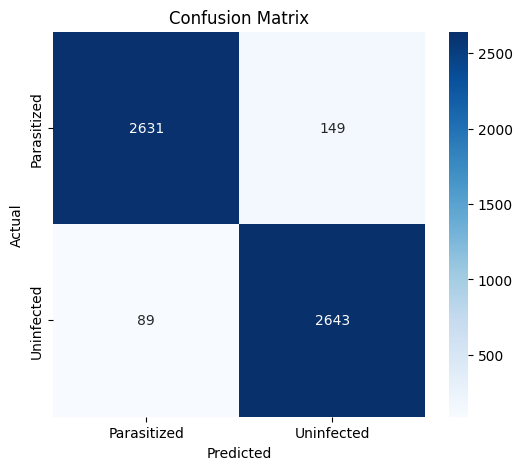

In [9]:
# Cell 5: Evaluation & Metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get Predictions
y_true = []
y_pred = []

for img, label in test_ds:
    y_true.extend(label.numpy())
    preds = adv_model.predict(img, verbose=0)
    y_pred.extend(np.round(preds).flatten())

# Metrics (F1-Score, Precision, Recall)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Parasitized', 'Uninfected']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Parasitized', 'Uninfected'], yticklabels=['Parasitized', 'Uninfected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

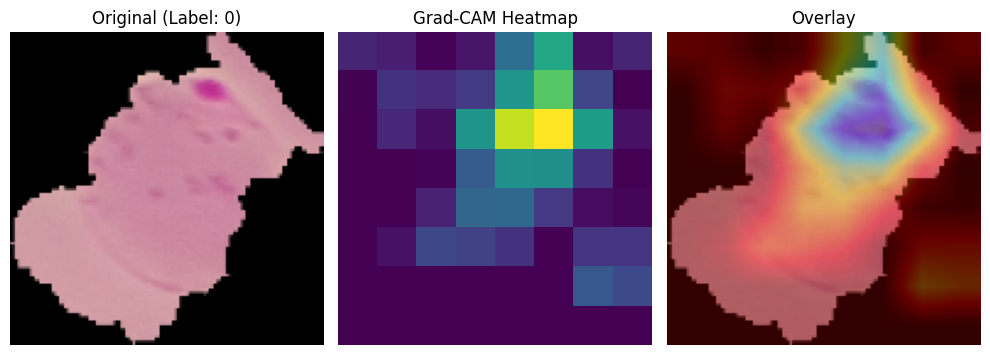

In [13]:
# Cell 6: Grad-CAM Implementation
# Requirement: "Visualize why the model made a decision"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # This approach explicitly traces the forward pass within the GradientTape scope
    # to ensure all operations are recorded and differentiable.

    with tf.GradientTape() as tape:
        # 1. Get the VGG16 base model (first layer of adv_model)
        vgg_base_model = model.layers[1] # Corrected from model.layers[0]

        # 2. Create a temporary model to extract features up to `last_conv_layer_name`
        # This model takes the `vgg_base_model`'s input and outputs the desired conv layer's features.
        temp_feature_extractor = tf.keras.models.Model(
            inputs=vgg_base_model.input,
            outputs=vgg_base_model.get_layer(last_conv_layer_name).output
        )

        # 3. Get the concrete activations of the last convolutional layer by passing the image through it.
        last_conv_layer_output_concrete = temp_feature_extractor(img_array)

        # 4. Explicitly watch these concrete activations. Gradients will be computed with respect to these.
        tape.watch(last_conv_layer_output_concrete)

        # 5. Pass the concrete activations of the last conv layer through the rest of the `adv_model` (the 'head').
        # The 'head' layers are all layers in `adv_model` after the `vgg_base_model` (which is layer 1).
        # Create a new input tensor for the 'head' part of the model, matching the shape of `last_conv_layer_output_concrete`.
        input_to_head_shape = last_conv_layer_output_concrete.shape[1:]
        head_input = tf.keras.Input(shape=input_to_head_shape)

        x = head_input
        for layer in model.layers[2:]: # Iterate over layers after the VGG base (which is layer 1)
            x = layer(x)

        # Create a temporary model for just the head of our advanced model
        model_head = tf.keras.models.Model(inputs=head_input, outputs=x)

        # Get the final predictions by passing the concrete conv features through the head model
        preds = model_head(last_conv_layer_output_concrete)

        # Determine the target class score for gradient computation
        if pred_index is None:
            # For binary classification with sigmoid output, preds[0][0] is P(class=1)
            predicted_class_idx = tf.cast(tf.round(preds[0][0]), tf.int32) # 0 or 1
            if predicted_class_idx == 0: # Parasitized
                # If predicted class is 0, we want the gradient of P(class=0)
                class_channel = 1 - preds[0][0]
            else: # Uninfected (class 1)
                # If predicted class is 1, we want the gradient of P(class=1)
                class_channel = preds[0][0]
        else:
            # Use the provided pred_index (0 for Parasitized, 1 for Uninfected)
            if pred_index == 0:
                class_channel = 1 - preds[0][0]
            else: # pred_index == 1
                class_channel = preds[0][0]

    # Compute gradients of the target class score with respect to the activations of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output_concrete)

    # Handle case where gradients might be None (e.g., if path is not differentiable)
    if grads is None:
        tf.print("Warning: Gradients are None. Cannot compute heatmap.")
        return np.zeros((IMG_SIZE, IMG_SIZE)) # Return a blank heatmap or handle as appropriate

    # Pooled gradients: Average intensity of the gradient for each filter
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by how important it is to the target class
    # Ensure last_conv_layer_output is for a single image (batch dimension removed)
    last_conv_layer_output = last_conv_layer_output_concrete[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize heatmap to [0, 1]
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon()) # Add epsilon for stability
    return heatmap.numpy()

# Find the last conv layer in VGG16 (usually 'block5_conv3')
last_conv_layer = 'block5_conv3'

# Get a sample image
for img, label in test_ds.take(1):
    sample_img = img[0]
    sample_label = label[0]
    break

# Prepare image for Grad-CAM
img_array = tf.expand_dims(sample_img, axis=0)
heatmap = make_gradcam_heatmap(img_array, adv_model, last_conv_layer) # Pass adv_model here

# Visualization
plt.figure(figsize=(10, 4))

ax1 = plt.subplot(1, 3, 1)
plt.imshow(sample_img)
plt.title(f"Original (Label: {int(sample_label)})")
plt.axis('off')

ax2 = plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis('off')

ax3 = plt.subplot(1, 3, 3)
# Overlay
heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
sample_img_uint8 = np.uint8(255 * sample_img)
superimposed_img = cv2.addWeighted(sample_img_uint8, 0.6, heatmap_resized, 0.4, 0)

plt.imshow(superimposed_img)
plt.title("Overlay")
plt.axis('off')

plt.tight_layout()
plt.show()